# BÀI TẬP VỀ NHÀ 

1. Thử nghiệm thuật toán trích xuất đặc trưng BoW với số lượng từ trong từ điển khác nhau. Vẽ biểu đồ độ chính xác trên tập test ứng với từng trường hợp.

2. Sử dụng thuật toán Grid search kết hợp với Cross Validation tìm tham số tốt nhất cho mô hình SVM.

3. Thay SVM bằng các bộ phân loại: K-Nearest Neighbors, Decision tree, Random forest. So sánh các kết quả và đưa ra nhận xét. 

4. Thử nghiệm bài toán Phân loại cảm xúc FERC-2013: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

## Load data
X: sample chứa list 1854 ảnh các ảnh các phương tiện giao thông.  
Y: nhãn tương ứng, được đánh số {0,1,2,3,4} tương ứng với 5 loại phương tiện giao thông.

In [2]:
def load_image(image_path):
    return cv2.imread(image_path)

In [3]:
def read_data(label2id):
    X = []
    Y = []

    for label in os.listdir('trainingset'):
        for img_file in os.listdir(os.path.join('trainingset', label)):
            img = load_image(os.path.join('trainingset', label, img_file))
            
            X.append(img)
            Y.append(label2id[label])
    return X, Y

In [4]:
# Label to id, used to convert string label to integer 
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)

## Trích xuất đặc trưng (features extraction)

Trích xuất đặc trưng SIFT (SIFT keypoints descriptor)

In [5]:
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.xfeatures2d.SIFT_create()

    for i in range(len(X)):
        _, des = sift.detectAndCompute(X[i], None)
        image_descriptors.append(des)

    return image_descriptors

In [6]:
image_descriptors = extract_sift_features(X)

## 1. Thử nghiệm thuật toán trích xuất đặc trưng BoW với số lượng từ trong từ điển khác nhau. Vẽ biểu đồ độ chính xác trên tập test ứng với từng trường hợp.

### 1.1. Trích xuất BoW với số lượng từ trong từ điển khác nhau

#### 1.1.1. Trước tiên ta sẽ xây dựng một list chứa tất cả các descriptors:

In [7]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 170686


#### 1.1.2. Sử dụng K-mean clustering để gom cụm

In [8]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []

    #### YOUR CODE HERE ####

    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    #### END YOUR CODE #####

    return bow_dict

#### 1.1.3. Thử nghiệm với số lượng từ trong từ điển khác nhau, lưu kết quả ra một list

In [9]:
num_clusters_range=list(range(20,201,10))+[250,300,400,500]
if not os.path.isfile('BoW.pydict'):
    BoW={}
    for num_clusters in num_clusters_range:
        print(num_clusters)
        BoW[num_clusters] = kmeans_bow(all_descriptors, num_clusters)
else:
    BoW=pickle.load(open('BoW.pydict','rb'))


### 1.2. Trích xuất đặc trưng SIFT ứng với mỗi BoW

In [10]:
from scipy.spatial.distance import cdist

In [11]:
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            argmin = np.argmin(distance, axis=1)

            for j in argmin:
                features[j] += 1
        X_features.append(features)
    return X_features

### 1.3. Training và đánh giá mô hình với tham số số lượng từ trong từ điển cho trước

In [12]:
def train_and_evaluate(BoW,num_clusters,X_train,Y_train,X_test,Y_test):
  print("num_clusters=",num_clusters)
  svm = sklearn.svm.SVC(C = 30)
  svm.fit(X_train, Y_train)
  train_score=svm.score(X_train, Y_train)
  test_score=svm.score(X_test, Y_test)
  print("Train set accuracy:",train_score)
  print("Test set accuracy:",test_score)
  return train_score,test_score
  

Đánh giá kết quả trên test set với số lượng từ trong từ điển khác nhau

In [13]:
from sklearn.model_selection import train_test_split

Score={}
for num_clusters in num_clusters_range:
  X_features = create_features_bow(image_descriptors, BoW[num_clusters], num_clusters)
  #fixed random_state=42, each iterations, training set and test set are splitted invariantly
  X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)
  Score[num_clusters]=train_and_evaluate(BoW[num_clusters],num_clusters,X_train,Y_train,X_test,Y_test)
  print("--------------------------------------")
  
  

num_clusters= 20
Train set accuracy: 1.0
Test set accuracy: 0.5309973045822103
--------------------------------------
num_clusters= 30
Train set accuracy: 1.0
Test set accuracy: 0.5902964959568733
--------------------------------------
num_clusters= 40
Train set accuracy: 1.0
Test set accuracy: 0.6657681940700808
--------------------------------------
num_clusters= 50
Train set accuracy: 1.0
Test set accuracy: 0.6630727762803235
--------------------------------------
num_clusters= 60
Train set accuracy: 1.0
Test set accuracy: 0.6792452830188679
--------------------------------------
num_clusters= 70
Train set accuracy: 1.0
Test set accuracy: 0.7115902964959568
--------------------------------------
num_clusters= 80
Train set accuracy: 1.0
Test set accuracy: 0.7142857142857143
--------------------------------------
num_clusters= 90
Train set accuracy: 1.0
Test set accuracy: 0.7304582210242587
--------------------------------------
num_clusters= 100
Train set accuracy: 1.0
Test set accur

Text(0, 0.5, 'accuracy')

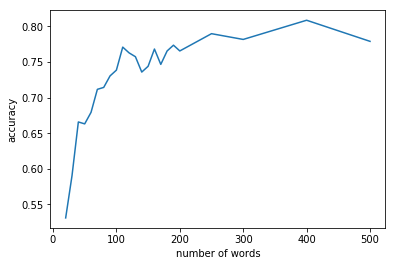

In [14]:
score_test=[x[1] for x in list(Score.values())]
plt.subplot()
plt.plot(list(Score.keys()),score_test)
plt.xlabel('number of words')
plt.ylabel('accuracy')

## 2. Sử dụng thuật toán Grid search kết hợp với Cross Validation tìm tham số tốt nhất cho mô hình SVM

Theo đánh giá ở trên, ta chọn số lượng từ trong từ điển (number of words) là 110.
Trích xuất đặc trưng, phân chia dữ liệu thành training set và test set.

In [15]:
num_cluster=110
X_features = create_features_bow(image_descriptors, BoW[num_clusters], num_clusters)
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)

Các tham số của model SVM mà ta quan tâm: C, kernel type, decision_function_shape.

In [16]:
from sklearn.model_selection import GridSearchCV
param_grid={'C':[10,30,100,300,1000,3000,10000],
           'kernel':['rbf','linear','poly','sigmoid'],
           'decision_function_shape':['ovr','ovo']}

gs=GridSearchCV(estimator=sklearn.svm.SVC(random_state=42),param_grid=param_grid,cv=3,n_jobs=4,verbose=10)
gs.fit(X_train,Y_train)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   55.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 168 out of 168 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=4,
             param_grid={'C': [10, 30, 100, 300, 1000, 3000, 10000],
                         'decision_function_shape': ['ovr', 'ovo'],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

Đánh giá kết quả:

In [17]:
best_svm=gs.best_estimator_
test_score=best_svm.score(X_test,Y_test)
print('Best parameter found:',gs.best_params_,sep='\n')
print('Best score on validation set:',gs.best_score_)
print('Accuracy on test set:',test_score)
global_metric={}
global_metric['SVM']=test_score


Best parameter found:
{'C': 10, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}
Best score on validation set: 0.8280512474713418
Accuracy on test set: 0.7870619946091644


## 3. Thay SVM bằng các bộ phân loại: K-Nearest Neighbors, Decision tree, Random forest. So sánh các kết quả và đưa ra nhận xét.

Cách tiếp cận chung: sử dụng grid search tìm ra tham số tốt cho mô hình.
Thực hiện tương tự như ở yêu cầu 2, đối với mô hình SVM

### 3.1. K-nearest neighbors

In [18]:
param_grid={'n_neighbors':[11,21,31,41,51,71,91,121],
           'weights':['uniform','distance']}

gs=GridSearchCV(estimator=sklearn.neighbors.KNeighborsClassifier(),param_grid=param_grid,cv=3,n_jobs=4,verbose=10)
gs.fit(X_train,Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done  46 out of  48 | elapsed:   13.8s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:   14.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [11, 21, 31, 41, 51, 71, 91, 121],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

Đánh gía kết quả

In [19]:
best_knn=gs.best_estimator_
test_score=best_knn.score(X_test,Y_test)
print('Best parameter found:',gs.best_params_,sep='\n')
print('Best score on validation set:',gs.best_score_)
print('Accuracy on test set:',test_score)
global_metric['KNN']=test_score

Best parameter found:
{'n_neighbors': 21, 'weights': 'distance'}
Best score on validation set: 0.466621712744437
Accuracy on test set: 0.4636118598382749


Độ chính xác rất thấp, mô hình unsupervise learning đơn giản này không phù hợp với bài toán.

### 3.2. Decision tree
Sử dụng bộ tham số mặc định, đánh giá kết quả trên tập test

In [20]:
decision_tree=sklearn.tree.DecisionTreeClassifier()
print(decision_tree)
decision_tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [21]:
test_score=decision_tree.score(X_test,Y_test)
print('Accuracy on test set:',test_score)
global_metric['Decision tree']=test_score

Accuracy on test set: 0.5956873315363881


### 3.3.Random forest
Tham số quan tâm: số lượng decision tree sử dụng trong mô hình.

In [22]:
from sklearn.ensemble import RandomForestClassifier
param_grid={'n_estimators':[10,30,50,70,100,150,200]}
gs=GridSearchCV(estimator=RandomForestClassifier(n_jobs=2,random_state=42),param_grid=param_grid,cv=3,n_jobs=2,verbose=10)
gs.fit(X_train,Y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  21 out of  21 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  21 out of  21 | elapsed:    5.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=2,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=2,
             param_grid={'n_esti

In [23]:
best_random_forest=gs.best_estimator_
test_score=best_random_forest.score(X_test,Y_test)
print('Best parameter found:',gs.best_params_,sep='\n')
print('Best score on validation set:',gs.best_score_)
print('Accuracy on test set:',test_score)
global_metric['Random Forest']=test_score

Best parameter found:
{'n_estimators': 200}
Best score on validation set: 0.75590020229265
Accuracy on test set: 0.7601078167115903


Dễ thấy số lượng decision tree càng nhiều, mô hình càng có độ chính xác cao (trade off với thời gian thực thi). Độ chính xác được cải thiện lớn so với decision tree thông thường (tăng thêm 15%)

### 3.4. Đánh giá các mô hình

In [24]:
print(global_metric)

{'SVM': 0.7870619946091644, 'KNN': 0.4636118598382749, 'Decision tree': 0.5956873315363881, 'Random Forest': 0.7601078167115903}


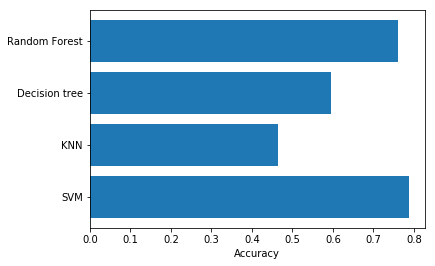

In [26]:
y_pos = np.arange(len(global_metric))
plt.barh(y_pos, list(global_metric.values()), align='center')
plt.yticks(y_pos, list(global_metric.keys()))
plt.xlabel('Accuracy')
plt.show()

SVM model hoạt động tốt nhất vì tính phù hợp của nó, và hơn nữa, số lượng từ trong từ điển là 110 cũng được tối ưu sử dụng đánh giá trên mô hình SVM. 